## Compute Global Mean Temperature anomaly for CMIP6 (each gcm individually)

In [9]:
import os 
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt 
from time import gmtime, strftime

import plot_gcm


mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =30
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize'] = 20 #30
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.major.pad']='8'
mpl.rcParams['ytick.major.pad']='8'
mpl.rcParams["figure.figsize"] = (15,10)

## Preindustrial temperatures
All temperature anomalies will be expressed relative to the global mean temperature averaged between 1850 and 1879 from HadCRUT5 (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JD032361). 

The folder cmpi6_select with all CMIP6 data used can be downloaded here: https://cluster.klima.uni-bremen.de/~julia/

In [2]:
CRUT5_path=os.path.join('cmip6_select','HadCRUT5')

First, we need to get the absolute global mean temperature, as all other values are relative to the mean from 1961-1990. This is 13.974 and can be found here:https://crudata.uea.ac.uk/cru/data/temperature/abs_glnhsh.txt

In [3]:
mean61_90 = 13.974

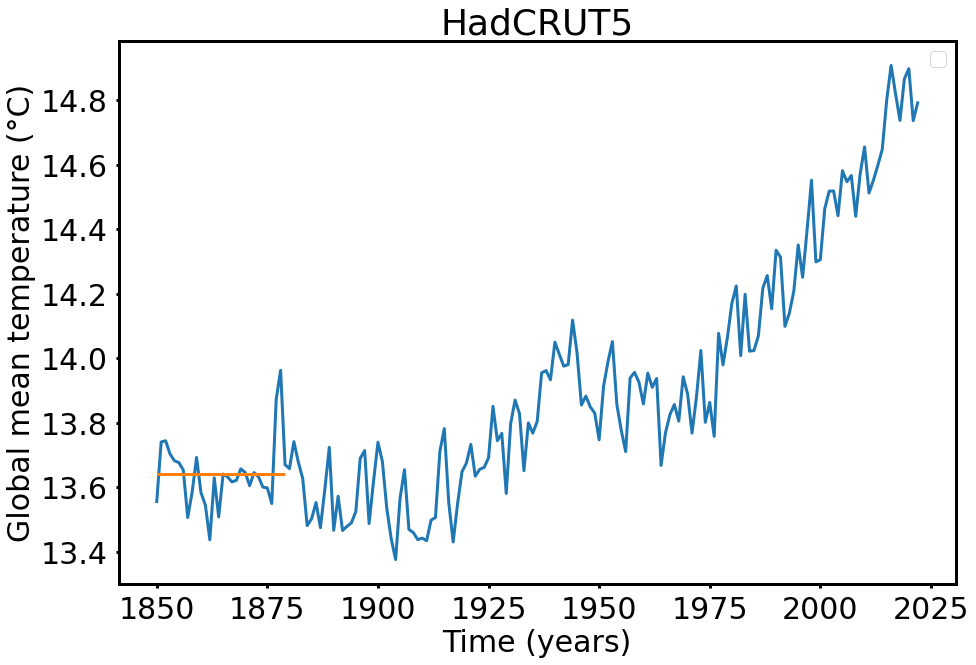

In [10]:
tas = pd.read_csv(os.path.join(CRUT5_path,'HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv')).set_index('Time').loc[:,'Anomaly (deg C)']
# calculate global mean temperature based on anomalies and mean from 1961-1990
HadCRUT5 = tas+mean61_90
# calulate preindustrial mean (1850-1879)
pre_tas = (HadCRUT5).loc[1850:1879].mean()

# plotting
(HadCRUT5).plot(label='HadCRUT5')
plt.hlines(y=pre_tas,xmin=1850,xmax=1879, color='C1', label='preindustrial mean (1850-1879)')
plt.title('HadCRUT5')
plt.ylabel('Global mean temperature (°C)')
plt.xlabel('Time (years)')
plt.legend('');

In [11]:
pre_tas

13.6401085831

## GCMs 

In [12]:
ex_2_hot=['FGOALS-f3-L', 'BCC-CSM2-MR', 'MRI-ESM2-0', 'MPI-ESM1-2-HR', 'ACCESS-CM2', 'MIROC6', 'CESM2', 'GISS-E2-2-H']
order=['CanESM5', 'NorESM2-MM', 'FGOALS-f3-L','BCC-CSM2-MR', 'MRI-ESM2-0','MPI-ESM1-2-HR','ACCESS-CM2', 'EC-Earth3', 'MIROC6','CESM2','GISS-E2-2-H','IPSL-CM6A-LR-INCA','E3SM-1-1']

In [13]:
def bias_correct_tas(temp, mean, year_range):
    # select in temp years
    ts_tmp_sel = temp.sel(time=slice(*year_range))
    # calculate mean temperature over year range
    ts_tmp_avg = ts_tmp_sel.mean(dim='time')
    # calculate anomalies to mean temperature
    ts_tmp = temp - ts_tmp_avg
    # add mean temperature of reference climate
    ts_tmp = ts_tmp + mean61_90
    return ts_tmp

In [127]:
path='cmip6_select'
ds = xr.DataArray()
for gcm in order:
    tas_file =  [os.path.join(path,'tas',file) for file in os.listdir('cmip6_select/tas') if file.split('.')[2]==gcm][0]
    tas_ds = xr.open_dataset(tas_file).assign_coords(gcm=gcm)
    
    # convert to yearly temperatures
    t_ds = tas_ds.resample(time='Y').mean().tas
    
    # area weighted temperatures 
    weights = np.cos(np.deg2rad(t_ds.lat))
    tas_weighted = t_ds.weighted(weights)
    
    # compute global mean and convert K to °C
    w_mean = tas_weighted.mean(("lon", "lat")) - 273.15
    w_mean['time'] = w_mean.time.dt.year
    
    # apply bias correction
    w_mean = bias_correct_tas(w_mean, mean61_90, ('1960','1990'))
    
    if gcm==order[0]:
        ds = w_mean
    else:
        ds = xr.concat([ds,w_mean], dim='gcm')
# add HadCRUT5 to ds
ds = xr.concat([ds,xr.DataArray(HadCRUT5).rename({'Time':'time'}).assign_coords(gcm='HadCRUT5')], dim='gcm')

In [200]:
anom_ds = (ds-pre_tas)
anom_ds = anom_ds.drop_vars({'height', 'member_id'})
anom_ds.attrs["description"] = "Global temperature Anomalies (bias corrected)\n relative to preindustial (1850-1879) conditions of HadCRUT5."
anom_ds.attrs["units"] = '°C'
anom_ds.attrs["creation_date"] = strftime("%Y-%m-%d %H:%M:%S", gmtime())
anom_ds.to_netcdf(os.path.join(path,'GMT_anomly.nc'))

In [197]:
anom_ds

<xarray.DataArray 'tas' (gcm: 14, time: 185)>
array([[ 2.21261582e-03, -2.53277566e-01, -1.82077956e-01, ...,
         2.15465106e+00,  2.27083701e+00,  2.47679917e+00],
       [ 4.23268691e-01,  4.42612144e-01,  3.37774860e-01, ...,
         1.42483501e+00,  1.46387675e+00,  1.34119477e+00],
       [-1.16856575e-01,  6.23307128e-02,  1.28334062e-01, ...,
         1.61891236e+00,  1.91956936e+00,  1.69070857e+00],
       ...,
       [-2.22934244e-01, -1.12124918e-01, -7.93490387e-02, ...,
                    nan,             nan,             nan],
       [ 3.09652827e-01,  5.36892161e-01,  7.14244604e-01, ...,
                    nan,             nan,             nan],
       [-8.37673631e-02,  1.00541617e-01,  1.04492347e-01, ...,
                    nan,             nan,             nan]])
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2030 2031 2032 2033 2034
  * gcm      (gcm) <U17 'CanESM5' 'NorESM2-MM' ... 'E3SM-1-1' 'HadCRUT5'
Attributes:
    description:     Global temperature Anomalies (bias corrected)\n relative...
    units:          °C
    creation_date:  2023-01-06 09:44:32

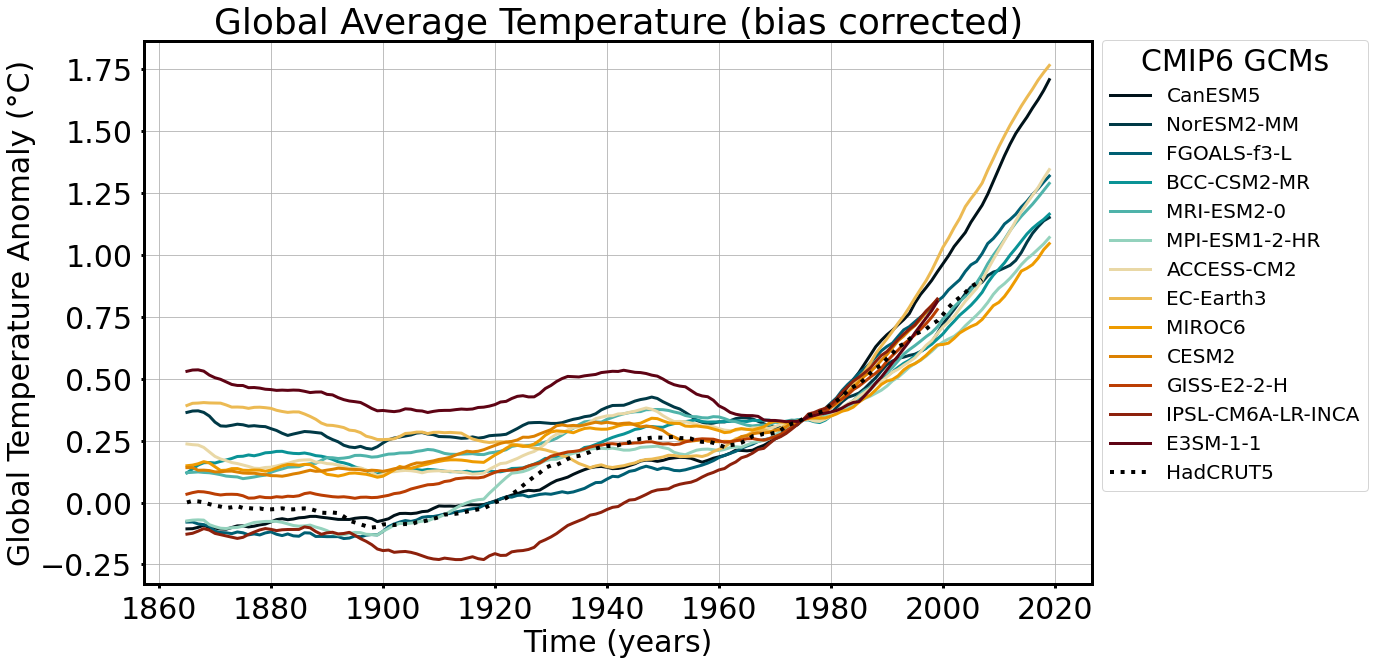

In [194]:

plt.figure(figsize=(17,10))
ax=plt.gca()

ax.set_prop_cycle(plot_gcm.create_color_cycler(3, n=len(order)))
anom_ds.rolling(time=31,center=True).mean().plot(hue='gcm')   
ax.set_title('')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Global Temperature Anomaly (°C)')
ax.set_title('Global Average Temperature (bias corrected)') 
ax.get_legend().set_bbox_to_anchor((1, 1.02))
ax.get_legend().set_title("CMIP6 GCMs")
plt.grid()


In [201]:
xr.open_dataset('cmip6_select/GMT_anomly.nc')

<xarray.Dataset>
Dimensions:  (time: 185, gcm: 14)
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2030 2031 2032 2033 2034
  * gcm      (gcm) object 'CanESM5' 'NorESM2-MM' ... 'E3SM-1-1' 'HadCRUT5'
Data variables:
    tas      (gcm, time) float64 ...